In [1]:
%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x26abc50abe0>,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65.0}

In [11]:
Sta_first_row = session.query(Station).first()
Sta_first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x26abc549550>,
 'elevation': 3.0,
 'id': 1,
 'latitude': 21.2716,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'station': 'USC00519397'}

# Exploratory Climate Analysis

<IPython.core.display.Javascript object>


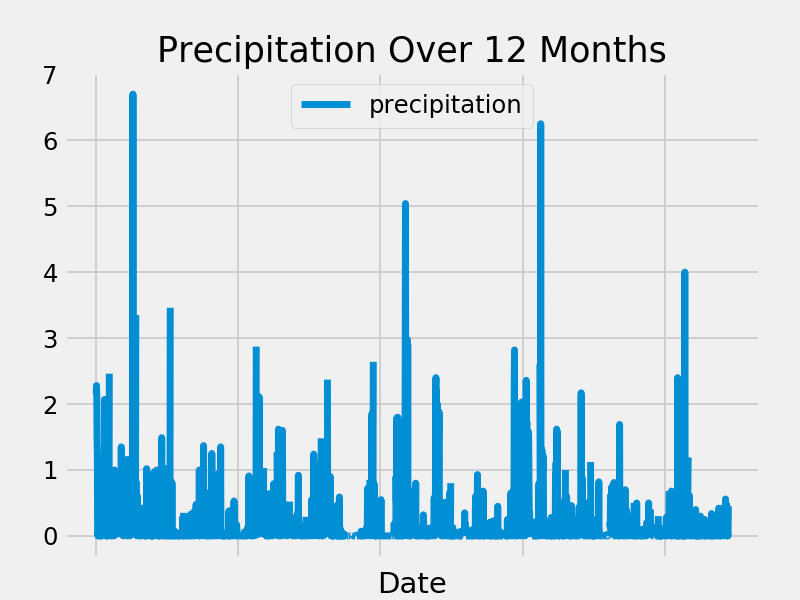

Text(0.5,1,'Precipitation Over 12 Months')

In [18]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
from datetime import timedelta
# Calculate the date 1 year ago from today (find 1 year from last day in data instead)
Measurement_dates = session.query(Measurement)
dates_list = []
# go through each row in Measurement and the data form the date column to a list
for row in Measurement_dates:
    dates_list.append(row.date)
# find the max day in the list, which is the latest day
last_day_in_data = max(dates_list)
#convert it from a string into datetime
las = dt.datetime.strptime(last_day_in_data, '%Y-%m-%d')
#get 1 year before the day by subtracting 365 days
one_year_before_last_day = las- timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
date_and_scores = session.query(Measurement).\
    filter(Measurement.date <= las).filter(Measurement.date >= one_year_before_last_day)

# Save the query results as a Pandas DataFrame and set the index to the date column
# got through each row in the query and get the date and prcp data
to_df_dates = []
to_df_prcp = []
for row in date_and_scores:
    to_df_dates.append(row.date)
    to_df_prcp.append(row.prcp)

# convert the lists into a dataframe
past_year_df = pd.DataFrame(to_df_prcp, index=to_df_dates)
past_year_df = past_year_df.rename(columns={0:"precipitation"})
past_year_df.head()

# Sort the dataframe by date
past_year_df_sorted = past_year_df.sort_index(ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
ax = past_year_df_sorted.plot()
ax.set_xlabel("Date")
ax.set_title("Precipitation Over 12 Months")

# Rotate the xticks for the dates


In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
past_year_df_sorted.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [19]:
# How many stations are available in this dataset?
stations_list = []
# got through each row in the query of the entire Measurement and add each station to a list
for row in Measurement_dates:
    stations_list.append(row.station)
# go through the list of stations and add each station to a new list if the station hasn't been added to the list yet
unique_stations = []
for i in stations_list:
    if i not in unique_stations:
        unique_stations.append(i)
# get the length of the unique_stations list to find out how many different stations there are in the data
print(len(unique_stations))        

9


In [14]:
# What are the most active stations?
# List the stations and the counts in descending order.
# create a counter list, starting each count at 0 for each unique station
station_counts = [0,0,0,0,0,0,0,0,0]
# create an index list to reference each index in the unique stations list
a = [0,1,2,3,4,5,6,7,8]
# use a nested loop to check how many times each station has gathered data
for j in stations_list:
    for b in a:
        if unique_stations[b] == j:
            station_counts[b] += 1

# zip the unique_stations and station_counts together to see how many times each station has reported data
stations_with_counts = zip(unique_stations, station_counts)   
stations_with_counts_list = list(stations_with_counts)
# reverse the order of the [1] to get the list in decending order by count
stations_with_counts_list_sort = sorted(stations_with_counts_list, key=lambda tup: tup[1], reverse=True)
stations_with_counts_list_sort

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [22]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
#create a variable equal to the name of the station with the most reports
most_active_station = stations_with_counts_list_sort[0][0]
# query for only that station
most_active_station_q = session.query(Measurement).\
    filter(Measurement.station == most_active_station)

# go through each row in the query and append the tobs data to a list  
temps = []
for row in most_active_station_q:
    temps.append(row.tobs)

# get and display the min, max, and average of the list
tmin = min(temps) 
tmax = max(temps)
tavg = np.mean(temps)
print(f"The min is {tmin}, the max is {tmax}, the average is {tavg} for station {most_active_station}.")
# print(len(temps))
# print(most_active_station)

The min is 54.0, the max is 85.0, the average is 71.66378066378067 for station USC00519281.


<IPython.core.display.Javascript object>


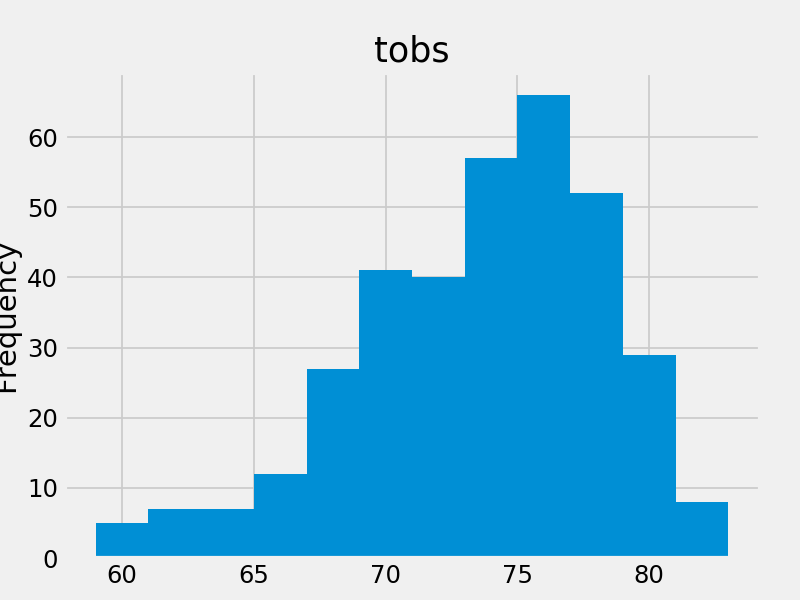

In [20]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_past_year = session.query(Measurement).\
    filter(Measurement.date <= las).filter(Measurement.date >= one_year_before_last_day).\
    filter(Measurement.station == most_active_station)

# go through each row in the query and append the tobs data to a list
to_df_temp = []
for row in most_active_past_year:
    to_df_temp.append(row.tobs)

# convert the list into a dataframe
station_Analysis_df = pd.DataFrame(to_df_temp)
station_Analysis_df = station_Analysis_df.rename(columns={0:"tobs"})

# create a histogram for the dataframe with 12 bins and display
station_Analysis_hist = station_Analysis_df.hist(bins=12)
plt.ylabel('Frequency')
plt.show()

In [16]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


<IPython.core.display.Javascript object>


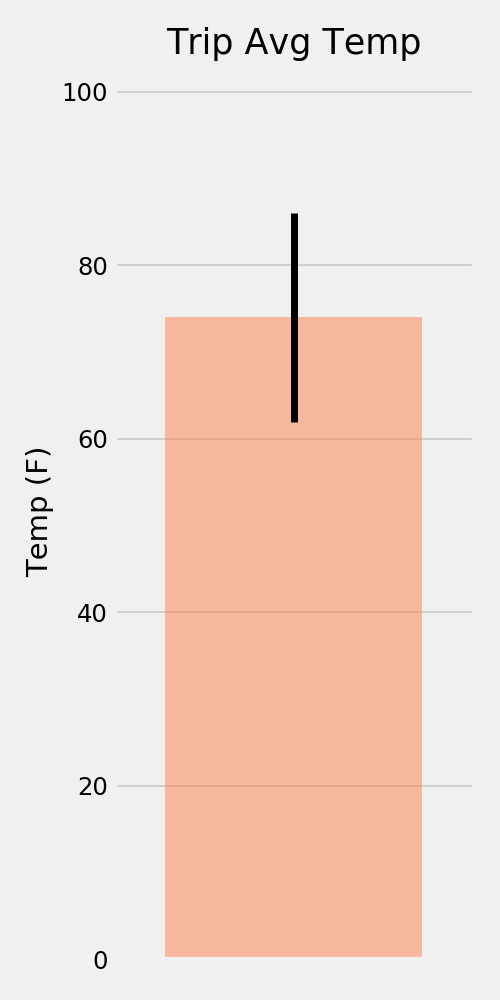

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [19]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.31), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.25), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.1), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.060000000000000005), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


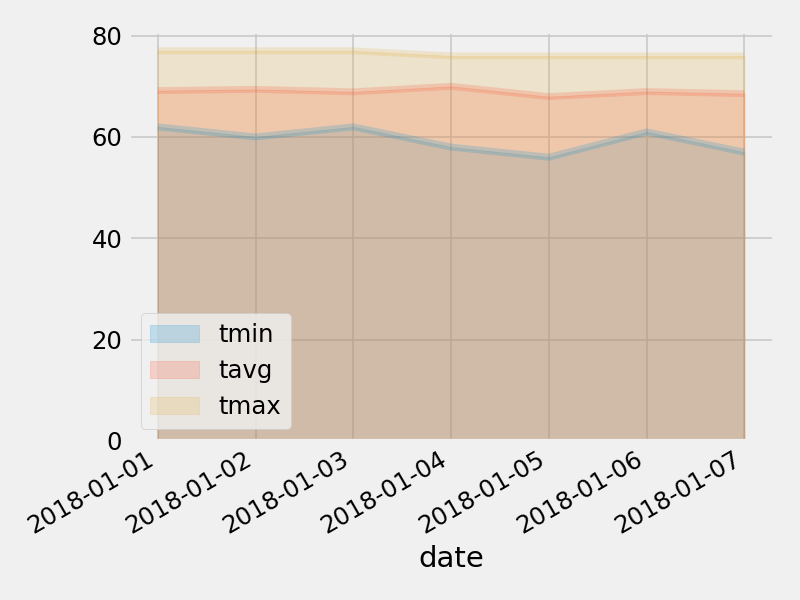

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
